In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import data_utils

sns.set_style('white', {'font.family':'serif'})
sns.set_context("paper", font_scale = 2)

In [2]:
# fetch random bit generator for reproducibility
bg = data_utils.get_random_gen()

# Dataset source

Data resource from Tzioumis, Konstantinos, 2018, "Data for: Demographic aspects of first names"

These come from mortgage applications, in which people self-identify with a race/ethnic category that corresponds to the US Census race/ethnic categories

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TYJKEZ 

Related paper: https://www.nature.com/articles/sdata201825

There's no way to find the URL for the data source, so I can't wget or curl it. :-/

In [3]:
input_file = 'firstnames.csv'
df = pd.read_csv(input_file, index_col=0)

# Drop an excess column
df.drop(columns=df.columns[-1], inplace=True)

# Capitalize to match counts data
df['firstname'] = df['firstname'].str.capitalize()

df.head()

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace
0,Aaron,3646,2.880,91.607,3.264,2.057,0.055,0.137
1,Abbas,59,0.000,71.186,3.390,25.424,0.000,0.000
2,Abbey,57,0.000,96.491,3.509,0.000,0.000,0.000
3,Abbie,74,1.351,95.946,2.703,0.000,0.000,0.000
4,Abby,262,1.527,94.656,1.527,2.290,0.000,0.000


In [4]:
df['obs'].sum()

2663364

# Dataset count frequencies

The propulation frequencies are observed from the mortgage applications, but this is problematic as a reflection for the population at large.  We plan to balance the names by 'frequency' in the US population of this set.

We use Social Security data with name + frequency + gender information: https://www.ssa.gov/oact/babynames/names.zip 

We use a script to tally up the name frequenices from 1960-2020.  This represents the population from ~2-82 years old.

In [5]:
frequency_file = 'names_aggregate_1960_2020.csv'
counts = pd.read_csv(frequency_file)
counts.head()

,Name,Count,ProportionFemale
0,Mary,727750,0.995941
1,Susan,426926,0.997110
2,Linda,319645,0.996490
3,Karen,470307,0.996409
4,Donna,285209,0.996918


### Merging datasets

In [6]:
# Merge, drop the duplicated columns
df_joined = df.merge(counts, how='left', left_on='firstname', right_on='Name')
df_joined.drop('Name', axis=1, inplace=True)
df_joined.head()

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace,Count,ProportionFemale
0,Aaron,3646,2.880,91.607,3.264,2.057,0.055,0.137,555734.0,0.007376
1,Abbas,59,0.000,71.186,3.390,25.424,0.000,0.000,1437.0,0.000000
2,Abbey,57,0.000,96.491,3.509,0.000,0.000,0.000,17052.0,0.999296
3,Abbie,74,1.351,95.946,2.703,0.000,0.000,0.000,14459.0,1.000000
4,Abby,262,1.527,94.656,1.527,2.290,0.000,0.000,56748.0,0.997480


We drop names that don't have social security counts.  These names are uncommon names among US citizens, and might represent names of foreign nationals purchasing mortgages in the US.  Ideally we would sample from all names, but due to a missing frequency data we remove some names from sampling.  As shown below, 73% correspond to API names.

In [7]:
no_counts_names = df_joined.query("Count.isnull()")
api_percent_of_no_counts = no_counts_names.query('pctapi > 50').shape[0] / no_counts_names.shape[0]
print(f"Proportion of names of majority API is {api_percent_of_no_counts:.2f} among {no_counts_names.shape[0]} names missing frequency data.")

df_joined.dropna(subset=['Count'], inplace=True)

Proportion of names of majority API is 0.73 among 141 names missing frequency data.


### Sampling names from race/ethnic groups

We choose a threshold of 75%.  In other words, if 75% of people with a given name self-identify with the same race/ethnicity group, we include the name as 'associated' with that particular race/ethnicity group.

In [8]:
def get_ordered_ix(df, n):
    df = df.sort_values('Count').reset_index()
    increment = n / df.shape[0]
    indices = [increment * x for x in range(df.shape[0])]
    df['index'] = indices
    return df

In [9]:
# Sampling names
given_names_df = pd.DataFrame()
for group in ["pctwhite", "pctblack", "pctapi", "pcthispanic", "pctaian", "pct2prace"]:
    temp = data_utils.name_lists_by_race(df_joined.query("Count<600000"), group, label=group)
    temp = temp.rename(columns={'firstname': 'GivenName'})
    temp['GivenName'] = temp['GivenName'].str.capitalize()
    temp['Ethnicity'] = group[3:]
    given_names_df = pd.concat([given_names_df, temp])

Found 2375 predominant pctwhite names
Found 21 predominant pctblack names
Found 446 predominant pctapi names
Found 238 predominant pcthispanic names
Found 0 predominant pctaian names
Found 0 predominant pct2prace names


In [10]:
# Compare means
given_names_df.groupby('Ethnicity')['Count'].describe()

,count,mean,std,min,25%,50%,75%,max
Ethnicity,,,,,,,,
api,446.0,488.901345,696.725819,5.0,73.00,279.0,620.25,5861.0
black,21.0,21572.619048,22831.338488,1462.0,9084.00,12770.0,25191.00,103950.0
hispanic,238.0,25121.760504,51850.771655,118.0,2093.75,6938.0,23596.75,488059.0
white,2375.0,41059.967158,84137.665413,5.0,2214.00,7343.0,35097.50,594931.0


The graph below shows population proportions for each racial/ethnic group, with frequency counts coming from mortgage data and social security datasets.  For example, if you randomly sample an individual based on population counts from the mortgage observation data, there is a 60% chance that person has a White-associated name.  Notably, we see that observation counts from mortgage data underrepresent Black-associated names compared to social security observation counts.  In other words, the mortgage dataset suggests Black-associated names are less frequent than they are in reality in the general US population.

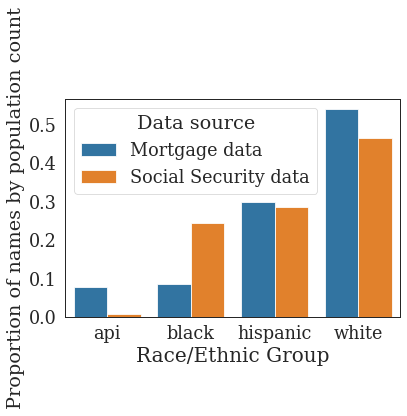

In [11]:
# Group data
per_group_counts = list()
for col, label in [('obs', 'Mortgage data'), ('Count', 'Social Security data')]:
    temp = given_names_df.groupby('Ethnicity')[col].mean().to_frame()
    temp = temp / sum(temp[col])
    temp['data_type'] = label
    temp['n'] = temp[col]
    per_group_counts.append(temp)
per_group_count_df = pd.concat(per_group_counts)

# Plot differences
p = sns.barplot(data=per_group_count_df, x=per_group_count_df.index, y='n', hue='data_type')
p.set_xlabel("Race/Ethnic Group", fontsize = 20)
p.set_ylabel("Proportion of names by population count")
p.legend(title='Data source')

In [12]:
# Resampling names
given_resampled_df = pd.DataFrame()
for group in ["pctwhite", "pctblack", "pctapi", "pcthispanic"]:
    temp = data_utils.name_lists_by_race(df_joined.query('Count>2000 and Count<120000', engine='python'), group, sample_size=1000, label=group[3:])
    temp = temp.rename(columns={'firstname': 'GivenName'})
    temp['GivenName'] = temp['GivenName'].str.capitalize()
    temp['Ethnicity'] = group[3:]
    given_resampled_df = pd.concat([given_resampled_df, temp])

Found 1000 predominant white names
Found 20 predominant black names
Found 14 predominant api names
Found 172 predominant hispanic names


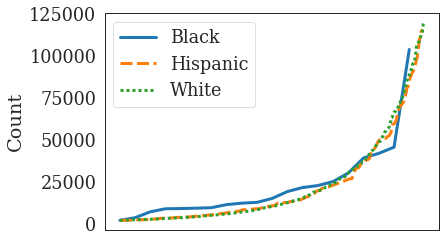

In [13]:
plot_1 = given_resampled_df.query("Ethnicity=='black'")
plot_1 = get_ordered_ix(plot_1, n=20)
temp1 = given_resampled_df.query("Ethnicity=='hispanic'")
temp1 = get_ordered_ix(temp1, n=20)
temp2 = given_resampled_df.query("Ethnicity=='white'")
temp2 = get_ordered_ix(temp2, n=20)
plot_1 = pd.concat([plot_1, temp1, temp2]).reset_index()

lar1_plot = sns.lineplot(data=plot_1, x='index', y='Count', hue='Ethnicity', style='Ethnicity', linewidth=3)
lar1_plot.set(xticklabels=[])
lar1_plot.set(xlabel=None)
lar1_plot.legend(labels=['Black', 'Hispanic', 'White'])
lar1_plot
plt.savefig("pii-lar1.png", dpi=300, bbox_inches="tight")

In [14]:
# Compare means
given_resampled_df.groupby('Ethnicity')['Count'].describe()

,count,mean,std,min,25%,50%,75%,max
Ethnicity,,,,,,,,
api,14.0,3326.857143,1349.110810,2021.0,2229.75,2733.5,4438.50,5861.0
black,20.0,22578.150000,22942.423924,2063.0,9261.00,13952.0,26469.25,103950.0
hispanic,172.0,21646.924419,25515.033869,2045.0,4509.25,10611.0,26208.00,115861.0
white,1000.0,22590.183000,27113.476079,2007.0,4236.75,10372.5,30067.50,119865.0


There are very few Black names in the total sample, and they all fall under 120K observations according to the social security dataset.  We provided restrictions when sampling White and Hispanic names in order to select names that had relatively similar count distributions.  We randomly sampled from names that had at least 2K observations and no more than 120K observations.

In [15]:
# We don't see a significant difference in means between the Hispanic, Black, and White groups.
given_resampled_df.head()
data_utils.sig_of_means(given_resampled_df, ["Ethnicity=='hispanic'", "Ethnicity=='white'"], col='Count', label='Hispanic/White')
data_utils.sig_of_means(given_resampled_df, ["Ethnicity=='black'", "Ethnicity=='white'"], col='Count', label='Black/White')
data_utils.sig_of_means(given_resampled_df, ["Ethnicity=='hispanic'", "Ethnicity=='black'"], col='Count', label='Black/Hispanic')

Report for Hispanic/White: MannwhitneyuResult(statistic=85786.0, pvalue=0.4792370447722226)
Report for Black/White: MannwhitneyuResult(statistic=8369.0, pvalue=0.10566366377064873)
Report for Black/Hispanic: MannwhitneyuResult(statistic=1434.0, pvalue=0.11241627266539922)


In [16]:
# API names have a significantly different distribution, and have less than 20 samples in the distribution.  
# Therefore we will handle API names seperately.
data_utils.sig_of_means(given_resampled_df, ["Ethnicity=='api'", "Ethnicity=='white'"], col='Count', label='API/White')
given_resampled_df = given_resampled_df.query("Ethnicity != 'api'")

Report for API/White: MannwhitneyuResult(statistic=1963.0, pvalue=1.8433072701312061e-06)


## Special handling of API names
API names were more abundant but had few observations per name (488 per name). There aren't enough Black and Hispanic associated names in the lower range to directly compare.  However, we can compare to White names with similar prevalence.

However, we can't simply sample from a range corresponding to API names, because White name counts are distributed uniformly, while API name counts are distributed exponentially.  Instead, we can sample exponentially, where we see a similar distribution.  This leaves 2 similar distributions for White and API names.

<AxesSubplot:xlabel='index', ylabel='Count'>

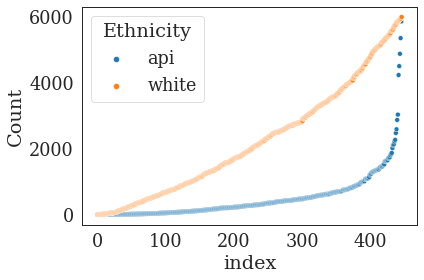

In [17]:
api_names = given_names_df.query("Ethnicity=='api'")
plot_white_api = api_names
limit = plot_white_api.shape[0]
given_names_df.query("Ethnicity=='white' and Count<6000").shape[0]
plot_white_api = get_ordered_ix(plot_white_api, limit)
temp = given_names_df.query("Ethnicity=='white' and Count<6000")#.sample(446, random_state=bg.bit_generator)
temp = get_ordered_ix(temp, limit)
plot_white_api = pd.concat([plot_white_api, temp])

sns.scatterplot(data=plot_white_api, x='index', y='Count', hue='Ethnicity')

<AxesSubplot:xlabel='index', ylabel='Count'>

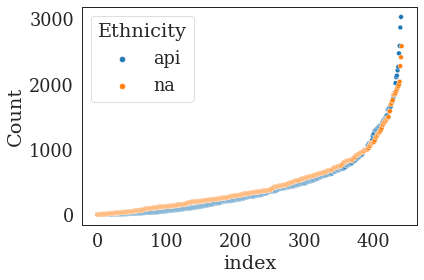

In [18]:
# An exponential distribution matches the distribution of the API data.
# We've removed 4 outliers above 4000 in count, the rest of the data fit the curve well.
digits = np.random.exponential(480, 442)
digits = sorted(digits)
exp_dist = pd.DataFrame(digits)
exp_dist['index'] = exp_dist.index
exp_dist['Ethnicity'] = 'na'
exp_dist['Count'] = exp_dist[0]

plot_exp_api = given_names_df.query("Ethnicity=='api' and Count<4000", engine='python')
plot_exp_api = get_ordered_ix(plot_exp_api, plot_exp_api.shape[0])
plot_exp_api = pd.concat([plot_exp_api, exp_dist])

sns.scatterplot(data=plot_exp_api, x='index', y='Count', hue='Ethnicity')

In [19]:
# Here we simply sample these names based on an exponential distribution.
digits = bg.exponential(480, 10000)
digits = [int(x) for x in digits]

column='pctwhite'
threshold=75
sample_size = 1000
query = f"{column} >= {threshold}"
df = df_joined.query(query, engine='python').copy()

i = 0
api_white_names = pd.DataFrame()
while api_white_names.shape[0] < sample_size:
    if not df[df['Count']==digits[i]].empty:
        api_white_names = pd.concat([api_white_names, df[df['Count']==digits[i]].iloc[0].to_frame().transpose()])
    i += 1
api_white_names['Ethnicity'] = 'white'
api_white_names.rename(columns={'firstname': 'GivenName'}, inplace=True)
api_white_names["Count"] = pd.to_numeric(api_white_names["Count"])
api_white_names = pd.concat([api_white_names, api_names.query("Count<4000")]).reset_index(drop=True)

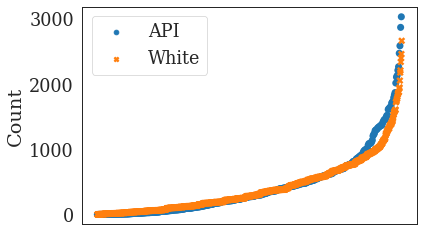

In [20]:
# The new samples are more closely matched.
plot_white_api_2 = api_white_names.query("Ethnicity=='api'")
limit = plot_white_api_2.shape[0]
plot_white_api_2 = get_ordered_ix(plot_white_api_2, limit)

temp = api_white_names.query("Ethnicity=='white'")#.sample(442, random_state=bg.bit_generator)
temp = get_ordered_ix(temp, limit)

plot_white_api_2 = pd.concat([plot_white_api_2, temp])
api_plot = sns.scatterplot(data=plot_white_api_2, x='index', y='Count', hue='Ethnicity', style='Ethnicity', s=50, edgecolor='none')


legend_labels, _= api_plot.get_legend_handles_labels()
api_plot.legend(legend_labels, ['API','White'], bbox_to_anchor=(0.4,1))

api_plot.set(xticklabels=[])
api_plot.set(xlabel=None)

api_plot
plt.savefig("pii-lar2.png", dpi=300, bbox_inches="tight")

In [21]:
# Compare means - looking good.
api_white_names.groupby('Ethnicity')['Count'].describe()

,count,mean,std,min,25%,50%,75%,max
Ethnicity,,,,,,,,
api,441.0,438.122449,506.502942,5.0,72.0,276.0,601.0,3037.0
white,1000.0,417.173000,417.539306,5.0,108.0,286.0,596.0,2669.0


In [22]:
# The means are not significantly different.
data_utils.sig_of_means(api_white_names, ["Ethnicity=='api'", "Ethnicity=='white'"], col='Count', label='API/White')

Report for API/White: MannwhitneyuResult(statistic=211033.5, pvalue=0.09674103361447745)


### Sanity check and save sampled names

In [ ]:
given_resampled_df.groupby(['Ethnicity'])['Count'].describe()

In [ ]:
given_resampled_df.to_csv('./name_lists/LAR_1.csv')

In [ ]:
api_white_names.groupby(['Ethnicity'])['Count'].describe()

In [ ]:
api_white_names.to_csv('./name_lists/LAR_2.csv')